In [1]:
from functions import *
import functions as fn

 [astropy.io.fits.verify]


SIMPLE  =                    T  / Standard Fits                                 
BITPIX  =                   16  / Bits par pixel                                
NAXIS   =                    2  / Nombre de dimensions                          
NAXIS1  =                 2720  / Axe des X                                     
NAXIS2  =                  512  / Axe des Y                                     
BSCALE  =           1.000000E0  / REAL = TAPE*BSCALE + BZERO                    
BZERO   =           3.276800E4  /                                               
OBJECT  = 'lampecuar'          / Nom de l'objet                                 
OBSERVAT= 'omm     '           / Observatoire                                   
EXPTIME =                 5.00  / Temps d'exposition (sec)                      
DARKTIME=                 5.00  / Temps total ecoule (sec)                      
IMAGETYP= 'comp    '           / Objet, Flat, Bias, etc.                        
DATE-OBS= '2019-10-27T08:19:

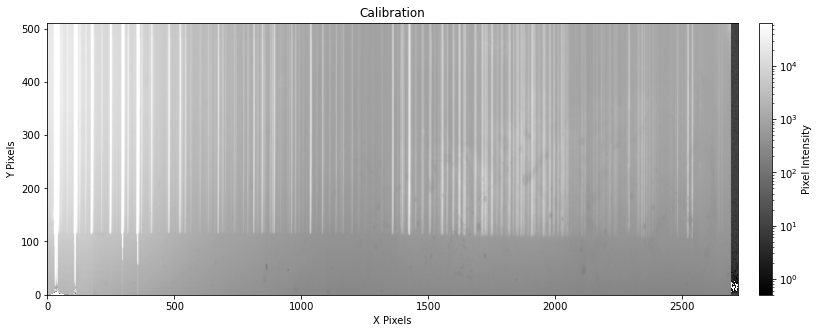

In [2]:
master_bias = np.load('data/master_bias.npy')
arc = fn.read_fits('data/calibration.fits', True)
arc = arc - master_bias
fn.plot_fits(arc, 'Calibration')

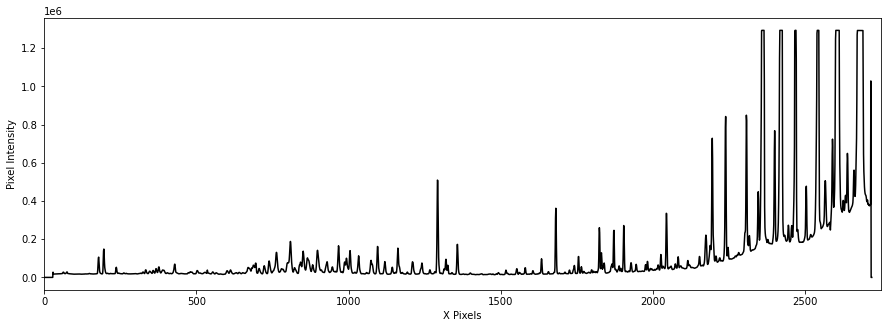

In [3]:
arc_spectrum = fn.spectrum(arc, 300, 20)
arc_spectrum = np.flip(arc_spectrum)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(arc_spectrum, color='black')    
ax.set_xlabel('X Pixels')
ax.set_ylabel('Pixel Intensity')
#ax.set_yscale('log')
ax.set_xlim(0, 2750)
plt.show()

In [4]:
cuar = fn.read_fits('data/cuar.fits', True)

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                29480 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2004-09-03T22:14:15' / Date FITS file was generated                  
IRAF-TLM= '15:14:15 (03/09/2004)' / Time of last modification                   
OBJECT  = '3250A   '           / Name of the object observed                    
OBSERVAT= 'KPNO              '  /  observatory                                  
OBSERVER= 'Willmarth         '  /  observers                                    
PROPID  = 'T&E               '  /  observing proposal ID                        
EXPTIME =             100.14

In [5]:
spatial_resolution = 1.73  # angstroms per pixel

lambda0 = 3053.5651855469  # angstroms
dlambda = 0.25  # angstroms
ref_pix = 1  # pixel number

wavelengths = np.arange(lambda0, lambda0 + len(cuar) * dlambda, dlambda)

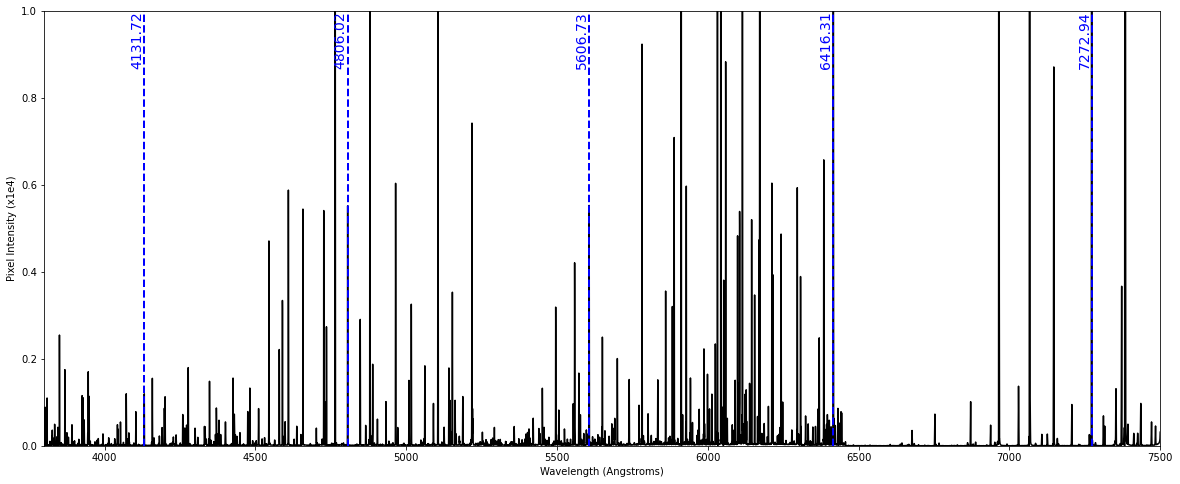

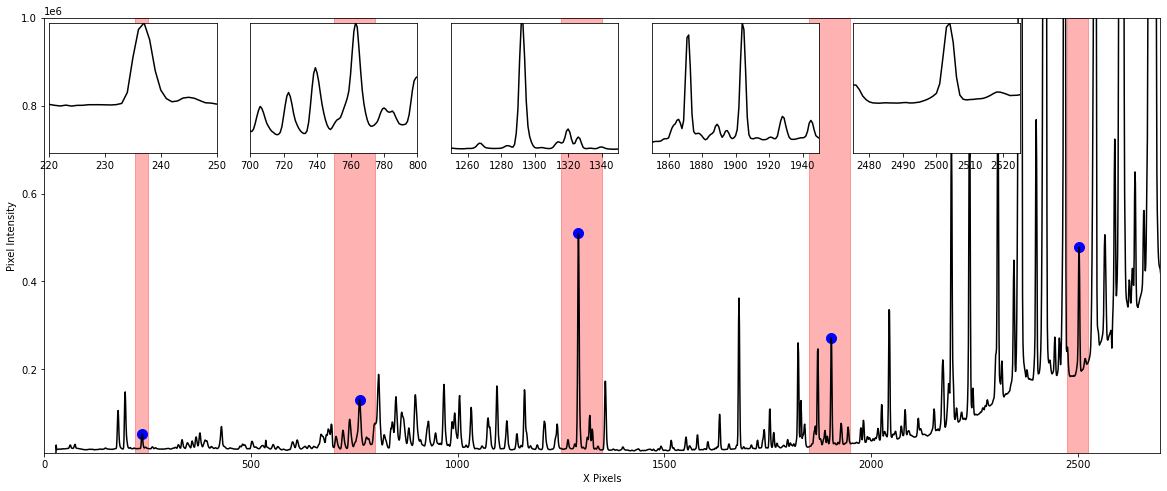

In [6]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(wavelengths, cuar, color='black')    
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Pixel Intensity (x1e4)')
#ax.set_yscale('log')
ax.set_xscale('linear')
ax.set_xlim(3800, 7500)
ax.set_ylim(0, 1e4)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.01f}".format(x / 1e4)))

# identifying lines
lines = [4131.72, 4806.02, 5606.73, 6416.31, 7272.94]
for x in lines:
    ax.axvline(x, color='blue', linestyle='--', linewidth=2)
    ax.text(x, ax.get_ylim()[1], f'{x}', rotation=90, verticalalignment='top', horizontalalignment='right', color='blue', fontsize=14)

plt.show()

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(arc_spectrum, color='black')    
ax.set_xlabel('X Pixels')
ax.set_ylabel('Pixel Intensity')
#ax.set_yscale('log')
ax.set_xlim(0, 2700)
ax.set_ylim(1e4, 1e6)

# identifying lines
ranges = [(220, 250), (700, 800), (1250, 1350), (1850, 1950), (2475, 2525)]
peaks = []

for i, (start, end) in enumerate(ranges):
    ax.axvspan(start, end, color='red', alpha=0.3)
    create_inset(arc_spectrum, ax, start, end, 0.18 * i, 0.0)

    max_value, peak = fn.find_maximum_peak_in_range(arc_spectrum, start, end)
    peaks.append(peak)
    ax.scatter(peak, max_value, color='blue', s=100)

plt.show()

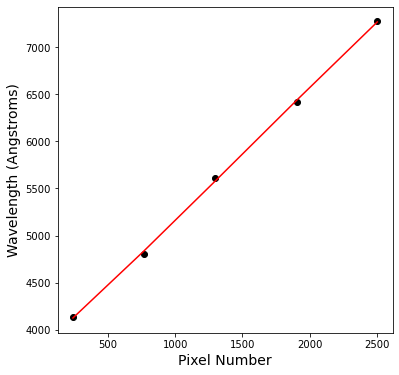

Slope: 1.3907746135149899


In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(peaks, lines, color='black')
coefficients = np.polynomial.legendre.legfit(peaks, lines, deg=3)
fit_line = np.polynomial.legendre.legval(peaks, coefficients)
plt.plot(peaks, fit_line, color='red')
plt.xlabel('Pixel Number', fontsize=14)
plt.ylabel('Wavelength (Angstroms)', fontsize=14)
plt.show()

# Perform a straight line fit
slope, intercept = np.polyfit(peaks, lines, 1)
print(f"Slope: {slope}")

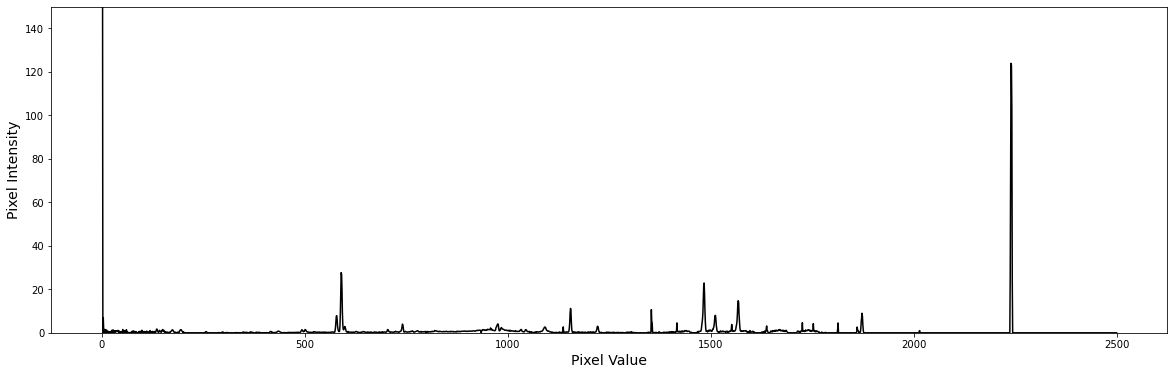

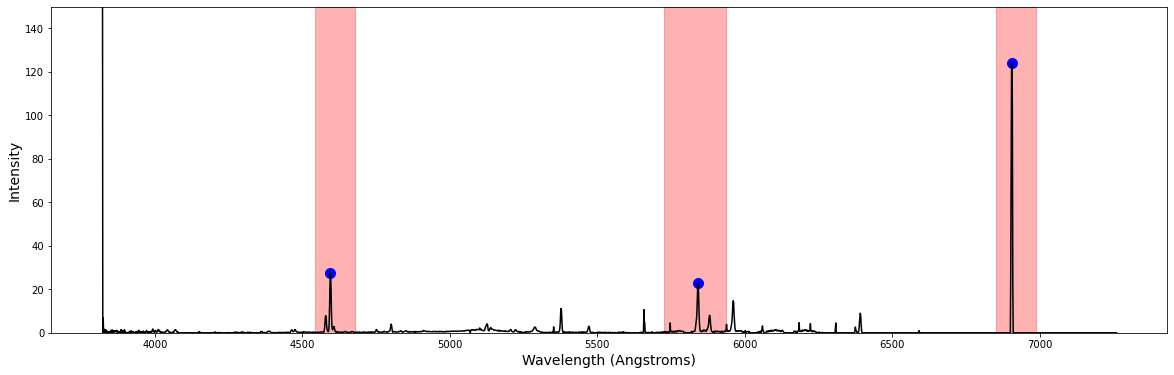

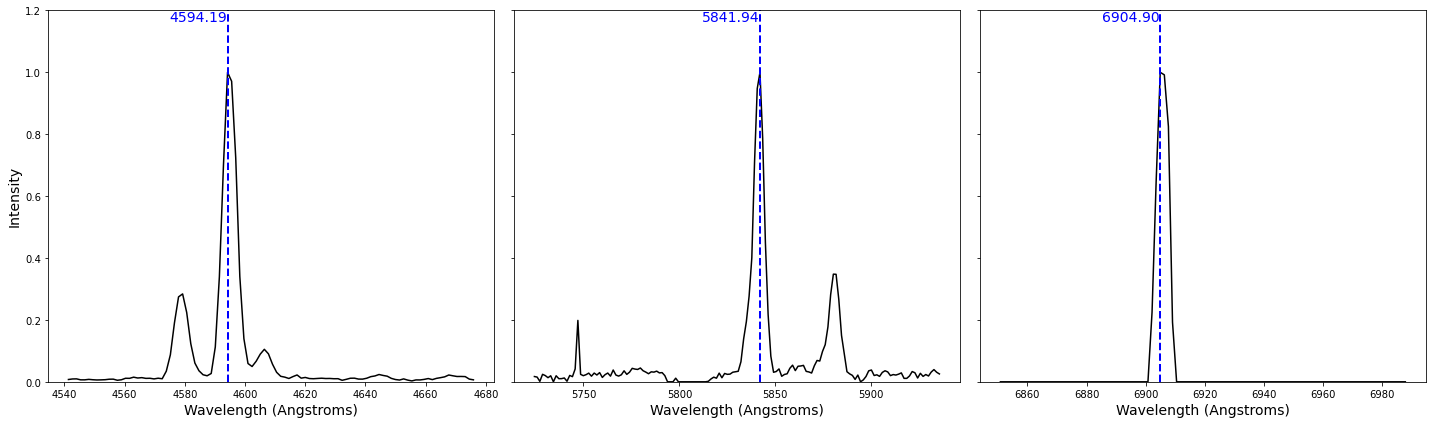

In [8]:
data = np.load('data/data.npy')
data_spectrum = fn.spectrum(data, 120, 30)
data_spectrum[data_spectrum < 0] = 0
# data_spectrum = np.flip(data_spectrum)
data_spectrum = data_spectrum[:2500]

pixels = np.arange(0, 2500)
wavelengths = np.polynomial.legendre.legval(pixels, coefficients)

# pixel plot
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_spectrum, color='black')    
ax.set_xlabel('Pixel Value', fontsize=14)
ax.set_ylabel('Pixel Intensity', fontsize=14)
#ax.set_xscale('log')
ax.set_ylim(0, 150)
plt.show()

# wavelength plot
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(wavelengths, data_spectrum, color='black')    
ax.set_xlabel('Wavelength (Angstroms)', fontsize=14)
ax.set_ylabel('Intensity', fontsize=14)
#ax.set_xscale('log')
ax.set_ylim(0, 150)

ranges = [(550, 650), (1400, 1550), (2200, 2300)]

for i, (start, end) in enumerate(ranges):
    ax.axvspan(
        np.polynomial.legendre.legval(start, coefficients), 
        np.polynomial.legendre.legval(end, coefficients), 
        color='red', 
        alpha=0.3
    )

peak_wavelengths = []
for start, end in ranges:
    max_value, peak = fn.find_maximum_peak_in_range(data_spectrum, start, end)
    peak = np.polynomial.legendre.legval(peak, coefficients)
    peak_wavelengths.append(peak)
    ax.scatter(peak, max_value, color='blue', s=100)

plt.show()

fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.subplots_adjust(hspace=0., wspace=0.)

for ax, (start, end), w in zip(axs, ranges, peak_wavelengths):
    norm_spectrum = data_spectrum[start:end] / np.max(data_spectrum[start:end])
    ax.plot(
        np.polynomial.legendre.legval(
            np.arange(start, end), 
            coefficients
        ), 
        norm_spectrum, 
        color='black'
    )
    ax.set_xlabel('Wavelength (Angstroms)', fontsize=14)
    if ax == axs[0]:
        ax.set_ylabel('Intensity', fontsize=14)
    ax.set_ylim(0, 1.2)
    ax.axvline(w, color='blue', linestyle='--', linewidth=2)
    ax.text(w, ax.get_ylim()[1], f'{w:.2f}', fontsize=14, verticalalignment='top', horizontalalignment='right', color='blue')

plt.tight_layout()
plt.show()